In [1]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import logging
import jax


logging.getLogger().setLevel(logging.INFO)
#logging.getLogger("absl").setLevel(logging.DEBUG)

set_matplotlib_formats("svg")


<IPython.core.display.Javascript object>

In [2]:
from math import log, exp
from sim import sim_and_fit, sim_wf
from estimate import posterior_decoding, sample_paths
from common import Observation
from plotting import plot_summary
rng = np.random.default_rng()


<IPython.core.display.Javascript object>

## Various models
(Note: for technical reasons estimation currently requires genic selection. The `h` parameter can still be used to simulate non-genic selection, but `h=0.5` is assumed during inference.)

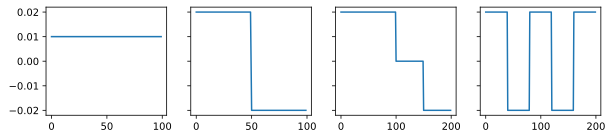

<IPython.core.display.Javascript object>

In [3]:
mdls = [
    {"s": [0.01] * 100, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {"s": [0.02] * 100 + [0.0] * 50 + [-0.02] * 50, "h": [0.5] * 200, "f0": 0.1},
    {"s": (([0.02] * 40 + [-0.02] * 40) * 3)[:200], "h": [0.5] * 200, "f0": 0.5},
]
model = mdls[1]
for m, ax in zip(mdls, plt.subplots(ncols=len(mdls), figsize=(10, 2), sharey=True)[1]):
    ax.plot(np.arange(len(m["s"])), m["s"])

## Posterior decoding

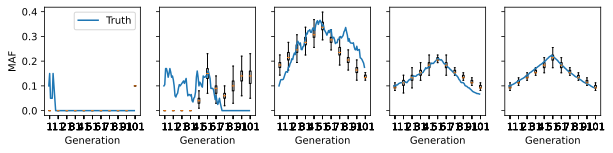

<IPython.core.display.Javascript object>

In [4]:
mdl = mdls[1]
n = 100
k = 10
fig, axs = plt.subplots(ncols=5, figsize=(10, 2), sharex=True, sharey=True)
for log_Ne, ax in zip(range(1, 6), axs):
    Ne = np.array([10 ** log_Ne] * len(mdl["s"]))
    af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
    obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

    data = [
        Observation(t=len(af) - t, sample_size=n, num_derived=oo, Ne=ne)
        for t, oo, ne in zip(range(0, len(af), k), obs, Ne)
    ]

    pd = posterior_decoding(
        data,  # observed data
        mdl["s"][::k],
    )
    pd.draw(ax)
    ax.plot(np.arange(len(af)), af, label="Truth")
    ax.set_xlabel("Generation")
axs[0].set_ylabel("MAF")
axs[0].legend()

## Estimation
(Single example).

JIT compiling takes a long time, but subsequent calls are fast:

In [5]:
import logging

logging.getLogger("estimate").setLevel(logging.INFO)

<IPython.core.display.Javascript object>

In [6]:
%%time  
## First call to JIT (slow)
sim_and_fit(model, seed=1, lam=1e2)

CPU times: user 17.7 s, sys: 782 ms, total: 18.5 s
Wall time: 17.9 s


{'t': (100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0),
 's': array([ 0.02606571,  0.05131949,  0.02958137, -0.00487671, -0.00156526,
        -0.04166452, -0.02644389, -0.03140592, -0.01884288, -0.01868352]),
 'obs': array([[100,   7],
        [100,  11],
        [100,  18],
        [100,  22],
        [100,  19],
        [100,  22],
        [100,  14],
        [100,  12],
        [100,   7],
        [100,   8],
        [100,   8]])}

<IPython.core.display.Javascript object>

In [7]:
%%time
## Second call, already jitted
sim_and_fit(model, seed=2, lam=1e2)

CPU times: user 1.62 s, sys: 436 ms, total: 2.06 s
Wall time: 1.69 s


{'t': (100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0),
 's': array([ 0.01827201,  0.01606859,  0.00743098,  0.0141424 , -0.00016136,
        -0.00980459, -0.01790375, -0.06254897, -0.02339317, -0.02670024]),
 'obs': array([[100,  11],
        [100,  18],
        [100,  17],
        [100,  18],
        [100,  21],
        [100,  21],
        [100,  18],
        [100,  19],
        [100,   8],
        [100,   8],
        [100,   6]])}

<IPython.core.display.Javascript object>

In [8]:
%%time
model = mdls[1]
res = []
for seed in range(20):
    res.append(sim_and_fit(model, seed=seed, lam=1e2))

CPU times: user 32.8 s, sys: 8.83 s, total: 41.6 s
Wall time: 33.3 s


<IPython.core.display.Javascript object>

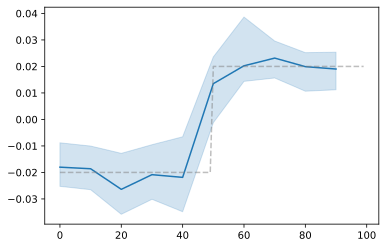

<IPython.core.display.Javascript object>

In [11]:
x, y = zip(*[(rr["t"][1:], rr["s"]) for rr in res])
plot_summary(plt.gca(), x, y, model["s"][::-1])

## Path sampling (stochastic traceback)

CPU times: user 3.74 s, sys: 40.5 ms, total: 3.78 s
Wall time: 3.74 s


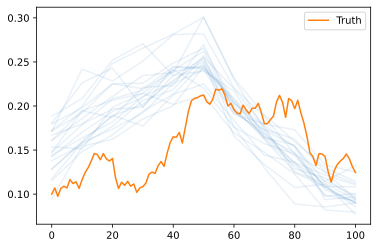

<IPython.core.display.Javascript object>

In [10]:
%%time
Ne = [int(1e3)]*100
rng = np.random.default_rng()
mdl = mdls[1]
af = sim_wf(Ne, mdl["s"], mdl["h"], mdl["f0"], rng)
n = 100
k = 10
obs = rng.binomial(n, af[::k])  # sample n haploids every d generations

times = list(range(0, len(af), k))
data = [
    Observation(t=t, sample_size=n, num_derived=oo, Ne=ne) for t, oo, ne in zip(times, obs, Ne)
]
paths = sample_paths(
    data,  # observed data
    mdl["s"][::k],
    100,  # number of discretizations
    20,  # number of paths
)
plt.plot(
    times,
    paths.T + np.random.normal(size=paths.T.shape, scale=0.01), # FIXME: correctly sample within discretized states
    color="tab:blue",
    alpha=0.1,
)  
plt.plot(np.arange(len(af)), af, color="tab:orange", label="Truth")
plt.legend()